In [4]:
import sys
import glob,os
import json
import pandas as pd
#import tensorflow as tf
import logging
import zipfile
#import re
#import datetime
import numpy as np
import os
import glob
import matplotlib
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import tensorflow as tf
from tensorflow.python import keras as ks
import sklearn as sk


In [5]:
class LoggerCritical:
    def __enter__(self):
        my_logger = logging.getLogger()
        my_logger.setLevel("CRITICAL")
    def __exit__(self, type, value, traceback):
        my_logger = logging.getLogger()
        my_logger.setLevel("DEBUG")


import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

with LoggerCritical():
    logging.debug("test block")

DEBUG:root:test


In [6]:
LOCAL_PROJECT_PATH = glob.glob(os.path.expanduser('~/MULE DATA'))[0]
assert os.path.exists(LOCAL_PROJECT_PATH)

In [7]:
THIS_DATASET = '20180807 201756'
df_records = pd.read_pickle(os.path.join(LOCAL_PROJECT_PATH,THIS_DATASET,'df_record.pck'))
frames=np.load(os.path.join(LOCAL_PROJECT_PATH,THIS_DATASET,'camera_numpy.zip'))
df_records.index = df_records['timestamp']
df_records.head()

,led_flags,mode,steering_signal,throttle_signal,timestamp
timestamp,,,,,
1533666054613,"[False, False, True, False]","{'recording': True, 'steering': 'human', 'thro...",-0.000000,0.81,1533666054613
1533666054946,"[True, False, False, False]","{'recording': True, 'steering': 'human', 'thro...",-0.134007,0.81,1533666054946
1533666128877,"[False, False, False, False]","{'recording': True, 'steering': 'human', 'thro...",-1.000000,0.93,1533666128877
1533666100553,"[False, False, True, False]","{'recording': True, 'steering': 'human', 'thro...",-0.000000,0.93,1533666100553
1533666147826,"[False, False, False, True]","{'recording': True, 'steering': 'human', 'thro...",-0.000000,1.29,1533666147826


DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/batman/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


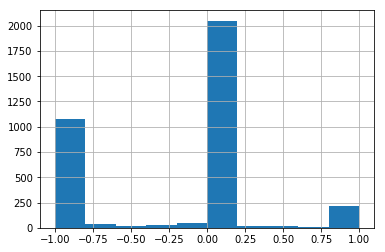

In [8]:
hist_steering = df_records['steering_signal'].hist()

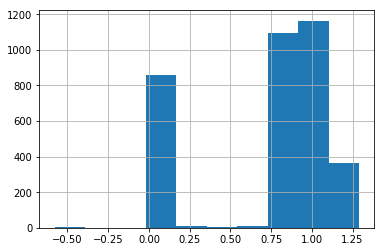

In [9]:
hist_throttle = df_records['throttle_signal'].hist()

In [10]:
# Conversion between categorical and floating point steering
def linear_bin(a):
    a = a + 1
    b = round(a / (2 / 14))
    arr = np.zeros(15)
    arr[int(b)] = 1
    return arr


def linear_unbin(arr):
    if not len(arr) == 15:
        raise ValueError('Illegal array length, must be 15')
    b = np.argmax(arr)
    a = b * (2 / 14) - 1
    return a


def bin_Y(Y):
    d = [ linear_bin(y) for y in Y ]
    return np.array(d)


def unbin_Y(Y):
    d = [ linear_unbin(y) for y in Y ]
    return np.array(d)

test_val = 0.5
print("Value", test_val)
Y_categorical = bin_Y([test_val])
print("Categorical", Y_categorical)
print("Back to value", unbin_Y(Y_categorical))

#print()


Value 0.5
Categorical [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Back to value [0.42857143]


In [11]:
##indices= sel_indices
def get_n_records(df_records, frames, indices):
    #this_frame = np.array[frames[idx] for idx in indices]
    these_frames = [frames[idx] for idx in indices]
    
    frame_array = np.stack([frames[idx] for idx in indices], axis=0)
    #this_steering = df_records[df_records['timestamp'] == idx]['steering_signal']
    these_steering = df_records[df_records['timestamp'].isin(indices)]['steering_signal'].values
    
    these_throttle = df_records[df_records['timestamp'].isin(indices)]['throttle_signal'].values
    
    timestamps = df_records[df_records['timestamp'].isin(indices)]['timestamp'].values
    #this_steering = df_records[idx]
    
    these_ts = [datetime.datetime.fromtimestamp(int(ts)/1000) for ts in timestamps]
    return frame_array,these_steering,these_throttle, these_ts


#frame, steering = get_record(df_records,frames, '1533666134582')

sel_indices = df_records.sample(5)['timestamp'].values
sel_frames, sel_steerings, sel_throttles, sel_ts = get_n_records(df_records, frames, sel_indices)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=30.0 to DejaVu Sans ('/home/batman/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


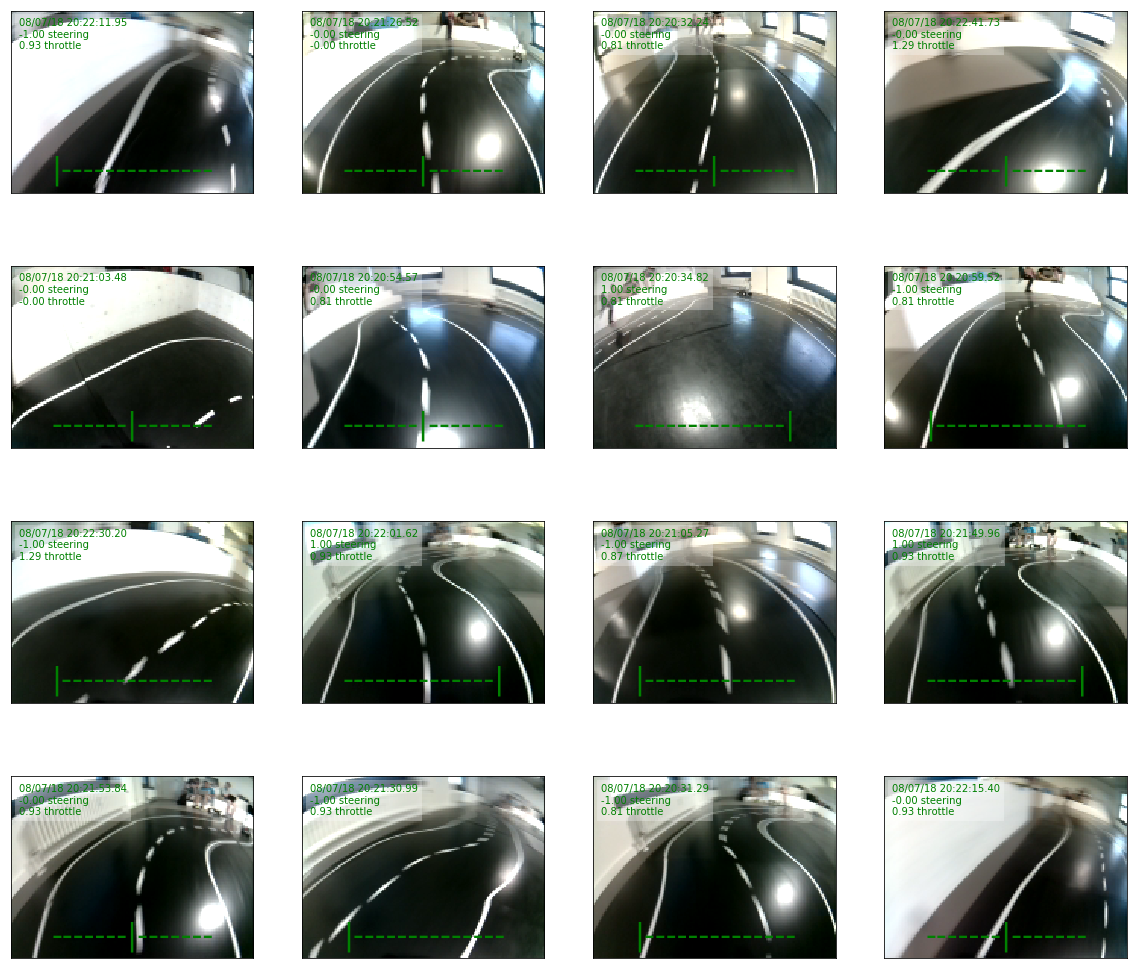

In [12]:
fig=plt.figure(figsize=[20,18],facecolor='white')
ROWS = 4
COLS = 4
NUM_IMAGES = ROWS * COLS
sel_indices = df_records.sample(NUM_IMAGES)['timestamp'].values
sel_frames, sel_steerings, sel_throttles, these_ts = get_n_records(df_records, frames, sel_indices)

for i,record in enumerate(zip(sel_frames, sel_steerings,sel_throttles,these_ts)):
    this_frame, this_steer, this_throttle,sel_ts = record
    
    steer_cat = ''.join(['|' if v else '-' for v in linear_bin(this_steer)])
    timestamp_string = sel_ts.strftime("%D %H:%M:%S.") + "{:.2}".format(str(sel_ts.microsecond))
    
    this_label = "{}\n{:0.2f} steering\n{:0.2f} throttle".format(timestamp_string,this_steer,this_throttle)
    y = fig.add_subplot(ROWS,COLS,i+1)
    y.imshow(this_frame)
    #plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    t = y.text(5,25,this_label,color='green',alpha=1)
    #t = plt.text(0.5, 0.5, 'text', transform=ax.transAxes, fontsize=30)
    t.set_bbox(dict(facecolor='white', alpha=0.3,edgecolor='none'))
    y.text(80,105,steer_cat,fontsize=30,horizontalalignment='center',verticalalignment='center',color='green')
    #plt.title()


# Data generator and utilities

In [13]:
class MuleDataGenerator(ks.utils.Sequence):
    """Generates data for Keras"""
    def __init__(self, list_IDs, path_frames, path_records, 
                 batch_size=32, dim=None, n_channels=None, n_classes=15, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        #self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.path_frames = path_frames
        assert os.path.exists(self.path_frames)
        self.path_records = path_records
        assert os.path.exists(self.path_records)
        logging.debug("** Initialize datagen **".format())
        logging.debug("Frames stored at: {}".format(self.path_frames))
        logging.debug("Records stored at: {}".format(self.path_records))
        logging.debug("{} samples over batch size {} yields {} batches".format(len(list_IDs),
                                                                                   params['batch_size'],
                                                                                   math.ceil(len(list_IDs)/params['batch_size']),))
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    # GET A BATCH!
    def __getitem__(self, index): 
        'Generate one batch of data'
        
        logging.debug("Generating batch {}".format(index))
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data by selecting these IDs
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __get_npy_arrays(self,list_IDs_temp):
        """Open the npz file and load n frames into memory"""
        # This is a pointer to the file
        npz_file=np.load(self.path_frames)
        #for k in list_ID_temp:
        #    npy_records.append(npz_file[k])
        #X_train = np.array(npy_records)
        
        frames_array = np.stack([npz_file[idx] for idx in list_IDs_temp], axis=0)
        logging.debug("Generating {} frames: {}".format(frames_array.shape[0], frames_array.shape))
        
        return frames_array
    
    def __get_records(self,list_IDs_temp):
        
        # Load the saved records
        df_records = pd.read_pickle(self.path_records)
        # Set the index to match
        df_records.index = df_records['timestamp']
        # Subset
        this_batch_steering = df_records.loc[list_IDs_temp]
        
        steering_values = this_batch_steering['steering_signal'].values
        
        #print(steering_values)
        steering_records_array = bin_Y(steering_values)
        
        #df_categorical_steering = df_records['steering_signal']
        #
        
        
        #records_array = df_records[]
        logging.debug("Generating {} records {}:".format(steering_records_array.shape[0],steering_records_array.shape))
        return steering_records_array
        
        #raise
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        #X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #y = np.empty((self.batch_size), dtype=int)
        
        X = self.__get_npy_arrays(list_IDs_temp)
        y = self.__get_records(list_IDs_temp)
        
        # Generate data
        #for i, ID in enumerate(list_IDs_temp):
            # Store sample
            #X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            #y[i] = self.labels[ID]
        #    pass

        return X, y

Partition

In [14]:
msk = np.random.rand(len(df_records)) < 0.8
partition = dict()
partition['train'] = df_records.index[msk].values
partition['validation'] = df_records.index[~msk].values
#labels = range(15)

In [15]:
params = {'dim': (160,120),
          'batch_size': 32,
          'n_classes': 15,
          'n_channels': 3,
          'shuffle': True,
          'path_frames':os.path.join(LOCAL_PROJECT_PATH,THIS_DATASET,'camera_numpy.zip'),
          'path_records':os.path.join(LOCAL_PROJECT_PATH,THIS_DATASET,'df_record.pck'),
         }

training_generator = MuleDataGenerator(partition['train'], **params)
validation_generator = MuleDataGenerator(partition['validation'], **params)
logging.debug("**")
logging.debug("Data Generators: {} samples over batch size {} yields ~{} batches: {} / {} train/val ".format(len(df_records),
                                                                                   params['batch_size'],
                                                                                   math.ceil(len(df_records)/params['batch_size']),
                                                                                   len(training_generator),
                                                                                  len(validation_generator)))



DEBUG:root:** Initialize datagen **
DEBUG:root:Frames stored at: /home/batman/MULE DATA/20180807 201756/camera_numpy.zip
DEBUG:root:Records stored at: /home/batman/MULE DATA/20180807 201756/df_record.pck
DEBUG:root:2815 samples over batch size 32 yields 88 batches
DEBUG:root:** Initialize datagen **
DEBUG:root:Frames stored at: /home/batman/MULE DATA/20180807 201756/camera_numpy.zip
DEBUG:root:Records stored at: /home/batman/MULE DATA/20180807 201756/df_record.pck
DEBUG:root:698 samples over batch size 32 yields 22 batches
DEBUG:root:**
DEBUG:root:Data Generators: 3513 samples over batch size 32 yields ~110 batches: 87 / 21 train/val 


In [16]:
first_batch = validation_generator[0]
last_batch = validation_generator[len(validation_generator)]

DEBUG:root:Generating batch 0
DEBUG:root:Generating 32 frames: (32, 120, 160, 3)
DEBUG:root:Generating 32 records (32, 15):
DEBUG:root:Generating batch 21
DEBUG:root:Generating 26 frames: (26, 120, 160, 3)
DEBUG:root:Generating 26 records (26, 15):


In [17]:
def baseline_steering_model():
    model = ks.models.Sequential()
    model.add(ks.layers.Conv2D(24, (5,5), strides=(2, 2), activation = "relu", input_shape=(120,160,3)))
    model.add(ks.layers.Conv2D(32, (5,5), strides=(2, 2), activation = "relu"))
    model.add(ks.layers.Conv2D(64, (5,5), strides=(2, 2), activation = "relu"))
    model.add(ks.layers.Conv2D(64, (3,3), strides=(2, 2), activation = "relu"))
    model.add(ks.layers.Conv2D(64, (3,3), strides=(1, 1), activation = "relu"))
    model.add(ks.layers.Flatten()) # This is just a reshape!
    model.add(ks.layers.Dense(100,activation="relu"))
    model.add(ks.layers.Dropout(0.1))
    model.add(ks.layers.Dense(50,activation="relu"))
    model.add(ks.layers.Dropout(0.1))
    model.add(ks.layers.Dense(15, activation='softmax', name='angle_out'))
    return model
blmodel = baseline_steering_model()

In [18]:
blmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 78, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 32)        19232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 17, 64)        51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 8, 64)          36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 6, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [19]:
blmodel.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=[ks.metrics.categorical_accuracy]
               )

# TRAIN

In [20]:
with LoggerCritical():
    history = blmodel.fit_generator(generator=training_generator,
                      validation_data=validation_generator,
                      use_multiprocessing=True,
                      workers=6,
                      epochs=3,
                      verbose=1,)
history_dict = history.__dict__

Epoch 1/3
87/87 [==============================] - 18s 207ms/step - loss: 1.8942 - categorical_accuracy: 0.6401 - val_loss: 0.8375 - val_categorical_accuracy: 0.7381
Epoch 2/3
87/87 [==============================] - 19s 221ms/step - loss: 0.8538 - categorical_accuracy: 0.7514 - val_loss: 0.7894 - val_categorical_accuracy: 0.7708
Epoch 3/3
87/87 [==============================] - 57s 651ms/step - loss: 0.7606 - categorical_accuracy: 0.7751 - val_loss: 0.8036 - val_categorical_accuracy: 0.7679


In [21]:
# Predict the raw probability vectors
def raw_predictions(model,frames):
    frame_array = np.stack([frames[idx] for idx in frames], axis=0)
    y_pred_categorical = model.predict(frame_array)
    #print(y_pred_categorical)
    #y_pred = unbin_Y(y_pred_categorical)
    return pd.DataFrame(y_pred_categorical,index = [idx for idx in frames])

df_ypred_probs = raw_predictions(blmodel,frames)
df_ypred_probs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1533666046324,0.532578,0.021350,0.023967,0.011209,0.029378,0.024091,0.031135,0.257376,0.004307,0.008762,0.013323,0.005027,0.011852,0.006792,0.018853
1533666126543,0.036841,0.014781,0.013034,0.019838,0.027640,0.015871,0.011054,0.456728,0.034528,0.040773,0.034688,0.021620,0.026384,0.045488,0.200731
1533666152576,0.741291,0.014061,0.008484,0.003467,0.008447,0.011901,0.008838,0.187194,0.001086,0.002373,0.004626,0.000670,0.002297,0.000576,0.004689
1533666027207,0.003625,0.001841,0.001275,0.004129,0.005157,0.000946,0.002364,0.747328,0.014397,0.013838,0.007902,0.001485,0.002698,0.013481,0.179534
1533666046199,0.489212,0.036799,0.016182,0.010166,0.019678,0.020892,0.025288,0.303449,0.006210,0.013273,0.012785,0.002138,0.006273,0.002563,0.035090


In [21]:
# Convert probability to the predicted argmax vector (one-hot)
def argmax_predictions(raw_probs):
    # Get the argmax of each row, as a 1D array
    argmaxxes = np.argmax(raw_probs.values,axis=1)
    # Initialize the output array
    arr = np.zeros((len(argmaxxes),15))
    
    # Iterate and set the max probability to 1, else 0
    for i,argmax in enumerate(argmaxxes):
        arr[i][argmax] = 1
    #frame_array = np.stack([frames[idx] for idx in frames], axis=0)
    #y_pred_categorical = model.predict(frame_array)
    #print(y_pred_categorical)
    #y_pred = unbin_Y(y_pred_categorical)
    return pd.DataFrame(arr,index = raw_probs.index)

df_ypred_onehot = argmax_predictions(df_ypred_probs)
df_ypred_onehot.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1533666046324,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533666126543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533666152576,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533666027207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1533666046199,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Convert the category back to a floating point steering value
def categorical_predictions(y_pred_raw):
    y_pred_cats = unbin_Y(y_pred_raw.values)
    #pd.DataFrame(y_pred_cats,index = [idx for idx in frames])
    return pd.DataFrame({"steering_pred":y_pred_cats},index = [idx for idx in frames])   
y_pred_floats = categorical_predictions(df_ypred_onehot)
y_pred_floats.head()

,steering_pred
1533666046324,-1.0
1533666126543,0.0
1533666152576,-1.0
1533666027207,0.0
1533666046199,-1.0


# Manual and Keras metric calculations

In [23]:
# Mean Squared Error from y_pred_floats
targets = df_records['steering_signal'].values
predictions = y_pred_floats['steering_pred'].values
N = predictions.shape[0]
sums_cumul = list()
for y_actual, y_pred in zip(targets,predictions):
    part_sum = (y_actual-y_pred)**2
    #print(y_actual, " - ",y_pred, "=",part_sum)
    sums_cumul.append(part_sum)
print("Total sum:",sum(sums_cumul))
print("MSE:",sum(sums_cumul)/N)

Total sum: 2055.6267952453577
MSE: 0.585148532663068


In [24]:
# Categorical accuracy (= number correctly categorized)
# Sum the correctly matching categories
targets = df_records['steering_signal'].values
predictions = y_pred_floats['steering_pred'].values
N = predictions.shape[0]
sums_cumul = list()
for y_actual, y_pred in zip(targets,predictions):
    y_actual_cats = linear_bin(y_actual)
    y_pred_cats = linear_bin(y_pred)
    #print(y_actual_cats)
    #print(y_pred_cats)
    sums_cumul.append(all(y_actual_cats == y_pred_cats))
    
    #part_sum = (y_actual-y_pred)**2
    #print(y_actual, " - ",y_pred, "=",part_sum)
    #sums_cumul.append(part_sum)
print("Total sum:",sum(sums_cumul))
print("Categorical Accuracy: {:0.1f}%".format(sum(sums_cumul)/N*100))

Total sum: 1672
Categorical Accuracy: 47.6%


In [25]:
sess = tf.InteractiveSession()
with sess.as_default():
    ks_categorical_accuracy = ks.metrics.categorical_accuracy(bin_Y(df_records['steering_signal']), bin_Y(y_pred_floats['steering_pred'])).eval()
    ks_mean_squared_error = ks.metrics.mean_squared_error(bin_Y(df_records['steering_signal']), bin_Y(y_pred_floats['steering_pred'])).eval()

    ks_categorical_crossentropy = ks.losses.categorical_crossentropy(ks.backend.constant(bin_Y(df_records['steering_signal'])), 
                                                                          ks.backend.constant(bin_Y(y_pred_floats['steering_pred']))).eval()
print("categorical_accuracy", sum(ks_categorical_accuracy)/N)
print("mean_squared_error",sum(ks_mean_squared_error)/N)
print("categorical_crossentropy",sum(ks_categorical_crossentropy)/N)

categorical_accuracy 0.47594648448619414
mean_squared_error 0.0698738020685064
categorical_crossentropy 8.446744613419426


# Epoch progress plot

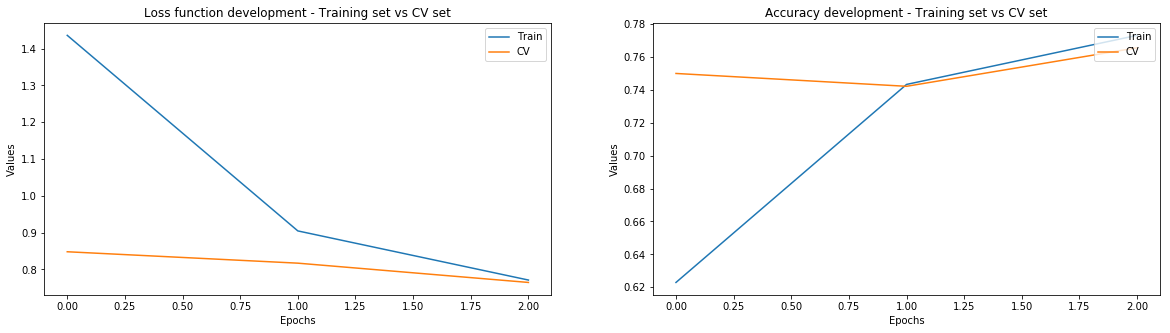

In [28]:
#model_title = "10 Epochs"
def plot_hist(history_dict, accuracy_name, model_title):
    #fig = plt.figure(figsize=(5,4))
    #fig=plt.figure(figsize=(20, 10),facecolor='white')

    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor='white')
    bgcolor = '0.15'
    bgcolor = 'white'
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5),sharey=False,facecolor=bgcolor)
    
    ax1.plot(history_dict['epoch'],  history_dict['history']['loss'],label="Train")
    ax1.plot(history_dict['epoch'],  history_dict['history']['val_loss'],label="CV")
    ax1.set_title("Loss function development - Training set vs CV set")
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Values')
    
    ax2.plot(history_dict['epoch'],  history_dict['history'][accuracy_name],label="Train")
    ax2.plot(history_dict['epoch'],  history_dict['history']['val_'+accuracy_name],label="CV")
    ax2.set_title("Accuracy development - Training set vs CV set")
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Values')
    
    plt.suptitle(model_title, fontsize=16)
    
    plt.show()

plot_hist(history_dict,'categorical_accuracy',model_title="")

In [34]:
def get_n_predictions(model,frames,indices):
    """Given a model and the input frames, select a subset (indices)
    and return the predictions.
    """
    these_frames = [frames[idx] for idx in indices]
    frame_array = np.stack([frames[idx] for idx in indices], axis=0)
    y_pred_categorical = model.predict(frame_array)
    #print(y_pred_categorical)
    y_pred = unbin_Y(y_pred_categorical)
    return y_pred


# Plot some results

In [ ]:
def get_n_records(df_records, frames, indices):
    #this_frame = np.array[frames[idx] for idx in indices]
    these_frames = [frames[idx] for idx in indices]
    
    frame_array = np.stack([frames[idx] for idx in indices], axis=0)
    #this_steering = df_records[df_records['timestamp'] == idx]['steering_signal']
    these_steering = df_records[df_records['timestamp'].isin(indices)]['steering_signal'].values
    
    these_throttle = df_records[df_records['timestamp'].isin(indices)]['throttle_signal'].values
    
    timestamps = df_records[df_records['timestamp'].isin(indices)]['timestamp'].values
    #this_steering = df_records[idx]
    
    these_ts = [datetime.datetime.fromtimestamp(int(ts)/1000) for ts in timestamps]
    return frame_array,these_steering,these_throttle, these_ts


In [1]:
def get_full_records(this_frames, this_df_records, this_y_pred_floats, this_indices):
    """Given a list of indices (timestamps), return a list of records
    
    frames:
        The frame images as a numpy array
    df_records:
        The steering at these times as a float
        The throttle at these times as a float
        The timestep as a datetime 
    y_pred_floats:
        The predicted steering at these times
    """
    records = list()
    for this_idx in this_indices:
        #print(this_idx)
        rec = dict()
        rec['frame'] = this_frames[this_idx]
        rec['steer'] = df_records.loc[this_idx]['steering_signal']
        #print(rec['steer'])
        rec['throttle'] = df_records.loc[this_idx]['throttle_signal']
        rec['timestamp_raw'] = df_records.loc[this_idx]['timestamp']
        rec['timestamp'] = datetime.datetime.fromtimestamp(int(rec['timestamp_raw'])/1000)
        rec['steer_pred'] = y_pred_floats.loc[this_idx]['steering_pred']
        records.append(rec)
    logging.debug("Created {} record dictionaries".format(len(this_indices)))
    
    return records
    #record = dict()
    #record['frame'] 
#     OLD METHOD, VECTORIZED:
#         rec['frame'] = np.stack(this_frames[this_idx] for idx in this_idx], axis=0)
#         rec['steer'] = df_records[df_records['timestamp'].isin(this_idx)]['steering_signal'].values
#         rec['throttle'] = df_records[df_records['timestamp'].isin(this_idx)]['throttle_signal'].values
#         timestamp = df_records[df_records['timestamp'].isin(this_idx)]['timestamp'].values
#         rec['timestamp'] = [datetime.datetime.fromtimestamp(int(ts)/1000) for ts in timestamp]
#         rec['steer_pred'] = y_pred_floats[y_pred_floats.index.isin(this_idx)]['steering_pred'].values    

In [2]:
# Image parameters
ROWS = 4
COLS = 4
NUM_IMAGES = ROWS * COLS


In [3]:
sel_indices = df_records.sample(NUM_IMAGES)['timestamp'].values
records = get_full_records(frames, df_records, y_pred_floats, sel_indices)

NameError: name 'df_records' is not defined

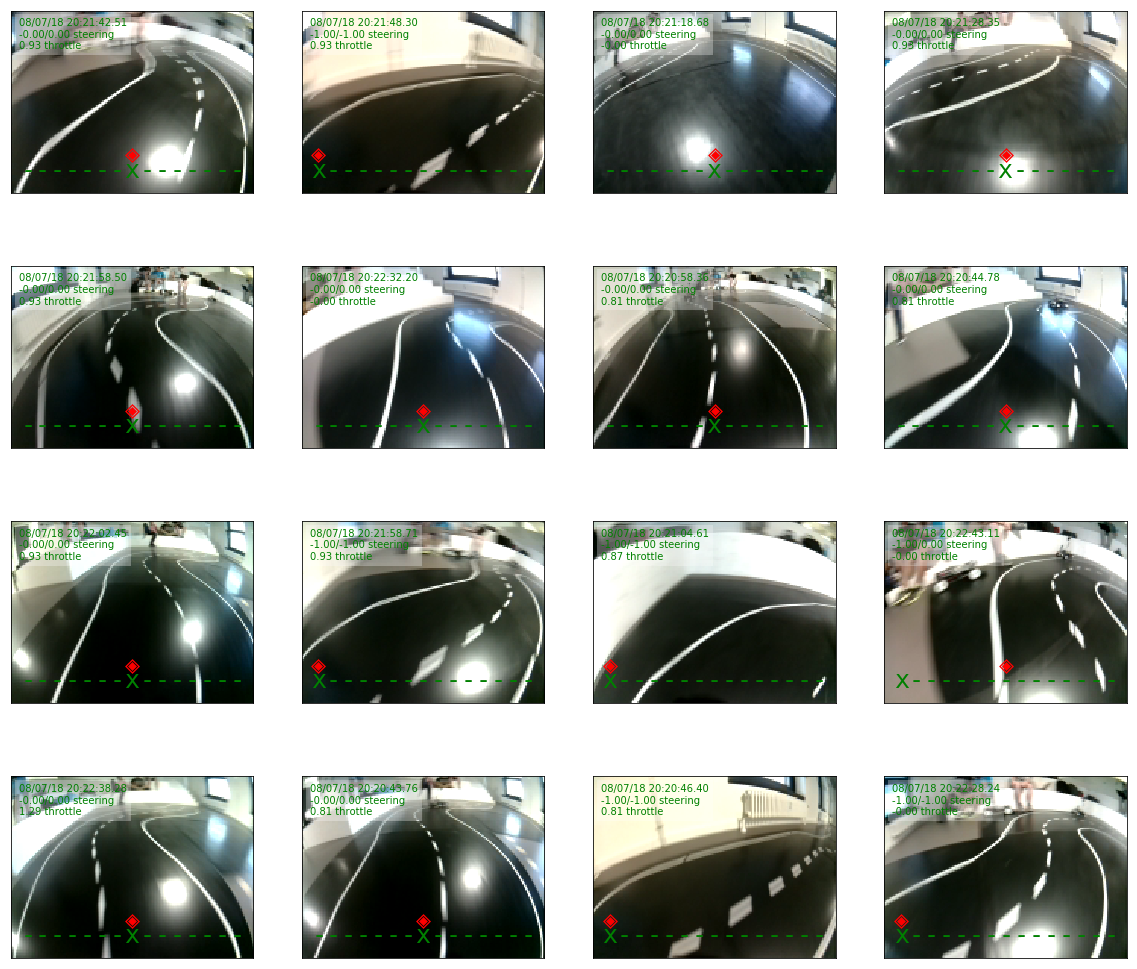

In [155]:
def gen_sample_frames(records):
    fig=plt.figure(figsize=[20,18],facecolor='white')

    for i,rec in enumerate(records):
        font_label_box = {
            'color':'green',
            'size':16,
        }
        font_steering = {'family': 'monospace',
                #'color':  'darkred',
                'weight': 'normal',
                'size': 25,
                }
        steer_actual = ''.join(['x' if v else '-' for v in linear_bin(rec['steer'])])
        steer_pred = ''.join(['◈' if v else ' ' for v in linear_bin(rec['steer_pred'])])
        timestamp_string = rec['timestamp'].strftime("%D %H:%M:%S.") + "{:.2}".format(str(rec['timestamp'].microsecond))

        this_label = "{}\n{:0.2f}/{:0.2f} steering \n{:0.2f} throttle".format(timestamp_string,rec['steer'],rec['steer_pred'],rec['throttle'])
        y = fig.add_subplot(ROWS,COLS,i+1)
        y.imshow(rec['frame'])
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)
        t = y.text(5,25,this_label,color='green',alpha=1)
        t.set_bbox(dict(facecolor='white', alpha=0.3,edgecolor='none'))

        y.text(80,105,steer_actual,fontdict=font_steering,horizontalalignment='center',verticalalignment='center',color='green')
        y.text(80,95,steer_pred,fontdict=font_steering,horizontalalignment='center',verticalalignment='center',color='red')

gen_sample_frames(records)

In [156]:
def gen_one_record_frame(rec)
    font_label_box = {
        'color':'green',
        'size':16,
    }
    font_steering = {'family': 'monospace',
            #'color':  'darkred',
            'weight': 'normal',
            'size': 45,
            }
    SCALE = 50
    HEIGHT_INCHES = 160*2.54/SCALE
    WIDTH_INCHES =  120*2.54/SCALE
    fig = plt.figure(frameon=False,figsize=(HEIGHT_INCHES,WIDTH_INCHES))
    #fig.set_size_inches(w,h)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(this_frame)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    # The labels in the box
    timestamp_string = rec['timestamp'].strftime("%D %H:%M:%S.") + "{:.2}".format(str(rec['timestamp'].microsecond))
    this_label = "{}\n{:0.2f}/{:0.2f} steering \n{:0.2f} throttle".format(timestamp_string,rec['steer'],rec['steer_pred'],rec['throttle'])
    t1 = ax.text(2,15,this_label,fontdict=font_label_box)
    t1.set_bbox(dict(facecolor='white', alpha=0.3,edgecolor='none'))

    # The steering HUD
    steer_actual = ''.join(['x' if v else '-' for v in linear_bin(rec['steer'])])
    steer_pred = ''.join(['◈' if v else ' ' for v in linear_bin(rec['steer_pred'])])
    t2 = ax.text(80,105,steer_actual,fontdict=font_steering,horizontalalignment='center',verticalalignment='center',color='green')
    t3 = ax.text(80,95,steer_pred,fontdict=font_steering,horizontalalignment='center',verticalalignment='center',color='red')

    this_fname = os.path.join("/home/batman/MULE_DATA2",'test.png')
    fig.savefig(this_fname)

SyntaxError: invalid syntax (<ipython-input-156-1cc359731788>, line 1)